In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv


In [2]:
import tensorflow  as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [3]:
# General Purpose Packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm

# Data Processing
import re
import emoji
import string
import nltk

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel

In [5]:
train_data = pd.read_csv("/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv",encoding='latin-1')
test_data = pd.read_csv("/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv",encoding='latin-1')

In [6]:
train_data.shape

(41157, 6)

In [7]:
train_data = train_data.ffill(axis = 0)
print(train_data.shape,test_data.shape)

(41157, 6) (3798, 6)


In [8]:
def change_sen(sentiment):
    if sentiment == "Extremely Positive":
        return 2
    elif sentiment == "Extremely Negative":
        return 0
    elif sentiment == "Negative":
        return 0
    elif sentiment == "Positive":
        return 2
    else:
        return 1
    
train_data['Sentiment'] = train_data['Sentiment'].apply(lambda x : change_sen(x))
test_data['Sentiment'] = test_data['Sentiment'].apply(lambda x : change_sen(x))

count_dict = train_data['Sentiment'].value_counts().to_dict()
Labels = list(count_dict.keys())
values = list(count_dict.values())

# **Look At the Data**

In [9]:
df_plot = train_data.groupby(by = 'TweetAt').count()
px.bar(x = df_plot.index,y =df_plot['Sentiment'],color = df_plot['Sentiment'])

In [10]:
px.pie(values = values,names = Labels,hole=.5,title = "Label Counts In Percentage")

In [11]:
df_plot = train_data.groupby(by = "Sentiment").count()
px.bar(df_plot,x = df_plot.index,y = df_plot['OriginalTweet'],color = ["Negative","Neural","Positive"],title = 'Count of Classes')

# **Cleaning Train & Test Data**

In [12]:
# Substituting Emoji from text
def remove_emoji(text):
    return re.sub(emoji.get_emoji_regexp(),r"",text)

# non_nece = Removing punctuation,links,mentions and \r\n new line characters
def remove_non_nece(text):
    text = text.replace("\r","").replace("\n","").lower()
    text = re.sub(r"(?:\@|https?\://)\S+","",text)
    text = re.sub(r"[^\x00-\x7f]",r"",text)
    banned_list = string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)


In [13]:
# Cleaning Train data
texts_new = []
for t in tqdm(train_data.OriginalTweet):
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(remove_non_nece(remove_emoji(t))))))

# Clearning Test Data
texts_new_test = []
for t in tqdm(test_data.OriginalTweet):
    texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(remove_non_nece(remove_emoji(t))))))
train_data['clean_text'] = texts_new
test_data['clean_text'] = texts_new_test

100%|██████████| 3798/3798 [00:05<00:00, 664.74it/s]


In [14]:
# Text len for train data
text_len_train = list()
for text in tqdm(train_data['clean_text']):
    text_len_train.append(len(text.split()))
train_data['text_len'] = text_len_train    

# Text len for test data
text_len_test = list()
for text in tqdm(test_data['clean_text']):
    text_len_test.append(len(text.split()))
test_data['text_len'] = text_len_test 

100%|██████████| 3798/3798 [00:00<00:00, 417879.03it/s]


In [15]:
train_df = train_data[train_data['text_len'] > 4]
test_df  = test_data[test_data['text_len'] >4 ]
print("Train Shape : ",train_df.shape)
print("Test Shape : ",test_df.shape)

Train Shape :  (40922, 8)
Test Shape :  (3792, 8)


# **BERT Tokenizer**

In [16]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [17]:
token_len = list()
for txt in tqdm(train_data['clean_text'].values):
    tokens = tokenizer.encode(txt,max_length = 512,truncation = True)
    token_len.append(len(tokens))
train_data['token_len'] = token_len
max_token_len = np.max(token_len)
print(f"Maximun Token Sentence Length : {max_token_len}")

100%|██████████| 41157/41157 [00:07<00:00, 5351.52it/s]

Maximun Token Sentence Length : 100


In [18]:
for idx,txt in enumerate(train_data['clean_text'].values):
    tokens = tokenizer.encode(txt,max_length = 512,truncation = True)
    if len(tokens) > 65:
        print(f"Index : {idx}, Text : {txt}")
        print("--"*50)
        break
        
print("The Text is Not In English Language, So We have to Drop Those Rows")

Index : 22, Text : we have amazing cheap deals for the covid2019 going on to help youtrialsmonthlyyearly and resonable prices subscriptionsjust dm us bestiptv iptv service iptv iptvdeals cheap iptv football hd movies adult cinema hotmovies iptvnew iptv2020 adult
----------------------------------------------------------------------------------------------------
The Text is Not In English Language, So We have to Drop Those Rows


# **Trim Train and Test Data**

In [19]:
train_data = train_data.sort_values(by = 'token_len',ascending = False).iloc[13:,:]
train_data = train_data.sample(frac = 1).reset_index(drop = True)

In [20]:
test_token_len = list()
for idx,txt in enumerate(tqdm(test_data['clean_text'].values)):
    token = tokenizer.encode(txt,max_length = 512,truncation = True)
    test_token_len.append(len(token))
test_data['token_len'] = test_token_len

100%|██████████| 3798/3798 [00:00<00:00, 5298.24it/s]


In [21]:
# Check whether Other language are present in text
for idx,txt in tqdm(enumerate(test_data['clean_text'].values)):
    token = tokenizer.encode(txt,max_length = 512,truncation = True)
    if len(token) > 80:
        print(f"Index : {idx}, Text : {txt}")

1040it [00:00, 5224.24it/s]

Index : 286, Text : so hard to decide as much as i want to hodl my 2 ccdcv4 token our place is declared to lock down due to covid19 i will use this to buy some food to stocktxnid093bd1db0c0d3a62af15883138a5f57d4cef35ae14e31e602b74489dd2524c7fmy b
Index : 345, Text : informoval jsem zstupce vech obchodnch etzc o aktulnch opatench vldy etzce jsou zsobovny na 95 take nen dvod panikait zsoby potravin fakt nedojdou nen opravdu dvod dnes obsadit a vykoupit supermarkety


3184it [00:00, 5309.51it/s]

Index : 2383, Text : ahora seguid llorando por el papel higinico que no he comprado porque an tengo seguid creando histeria y preocupacin poniendo fotos de gente en pnico y estanteras vacas que yo seguir yendo a comercios responsables de barrio donde nos cuidan hoy y siempre gracias


3798it [00:00, 5290.30it/s]


In [22]:
test_data = test_data.sort_values(by = 'token_len',ascending = False).iloc[5:,:]
test_data = test_data.sample(frac = 1).reset_index(drop = True)

Now The data clearning is completed. You can clean data furture, If you have any ideas. 

# Train - Validation - Test Split

In [23]:
X = train_data['clean_text']
y = train_data['Sentiment']

X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size = 0.2,stratify = y,random_state = 42)

X_test = test_data['clean_text']
y_test = test_data['Sentiment']

In [24]:
X_train

12743    definitely agree they tell you to stay home bu...
27405    going out be sure youre protected face mask sa...
40494    consumer finance monitor launches banking and ...
27948    bravo supermarkets in small country towns look...
2278     so here you are tweeting about a non essential...
                               ...                        
36545    retail store closures in the us could explode ...
27845    stimulating the economy is the wrong prescript...
27784    prices up stock down and self absorbed greedy ...
28930    south africa s commercial ports remain open fo...
15140    supermarket forced to throw out 35k of fresh f...
Name: clean_text, Length: 32915, dtype: object

# One Hot Encoding 

In [25]:
one_enc = OneHotEncoder()
y_train = one_enc.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
y_valid = one_enc.fit_transform(np.array(y_valid).reshape(-1,1)).toarray()
y_test = one_enc.fit_transform(np.array(y_test).reshape(-1,1)).toarray()

In [26]:
y_train

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [27]:
print(f"TRAINING DATA : {X_train.shape[0]}\nVALIDATION DATA : {X_valid.shape[0]}\nTESTING DATA : {X_test.shape[0]}")

TRAINING DATA : 32915
VALIDATION DATA : 8229
TESTING DATA : 3793


# **Padding**

In [28]:
MAX_LEN = 128

In [29]:
def tokenize(data,max_len = MAX_LEN):
    input_ids = list()
    attention_mask = list()
    for i in tqdm(range(len(data))):
        encoded = tokenizer.encode_plus(data[i],
                                        add_special_tokens = True,
                                        max_length = MAX_LEN,
                                        padding = 'max_length',
                                        return_attention_mask = True
                                       )
        input_ids.append(encoded['input_ids'])
        attention_mask.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_mask)

In [30]:
train_input_ids, train_attention_masks = tokenize(X_train.values, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid.values, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test.values, MAX_LEN)

100%|██████████| 3793/3793 [00:00<00:00, 4642.03it/s]


In [31]:
train_input_ids

array([[  101,  5791,  5993, ...,     0,     0,     0],
       [  101,  2183,  2041, ...,     0,     0,     0],
       [  101,  7325,  5446, ...,     0,     0,     0],
       ...,
       [  101,  7597,  2039, ...,     0,     0,     0],
       [  101,  2148,  3088, ...,     0,     0,     0],
       [  101, 17006,  3140, ...,     0,     0,     0]])

# **BERT Modelling**

In [32]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

2022-09-16 21:32:17.750662: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-16 21:32:17.751823: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-16 21:32:17.752489: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-16 21:32:17.753452: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [33]:
def create_model(bert_model,max_len = MAX_LEN):
    #params
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()
    
    input_ids = tf.keras.Input(shape = (max_len,),dtype = 'int32')
    attention_masks = tf.keras.Input(shape = (max_len,),dtype = 'int32')
    
    embeddings = bert_model([input_ids,attention_masks])[1]
    
    x = tf.keras.layers.Dense(16,activation = 'relu',kernel_regularizer = 'l2')(embeddings)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(3,activation = 'softmax')(x)
    
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    
    model.compile(opt,loss=loss,metrics = accuracy)
    return model
    
model = create_model(bert_model,MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           12304       tf_bert_model[0][1]          

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


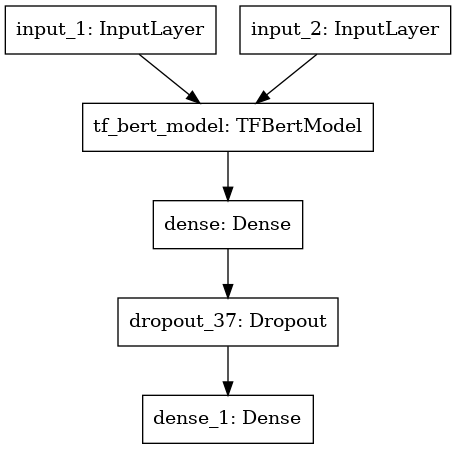

In [34]:
tf.keras.utils.plot_model(model)

In [35]:
with strategy.scope():
    bert_model = TFBertModel.from_pretrained('bert-base-uncased')
    model = create_model(bert_model,MAX_LEN)   

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [38]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(mode='min',patience=5)
# history_bert = model.fit([train_input_ids,train_attention_masks],y_train,validation_data = ([val_input_ids,val_attention_masks],y_valid),epochs = 5,batch_size = 30*4,callbacks = early_stopping)

In [ ]:
history_bert.history.keys()

In [ ]:
plt.plot(history_bert.history['categorical_accuracy'])
plt.plot(history_bert.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_bert.history['loss'])
plt.plot(history_bert.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()